In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from number_recognition_network import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df_pd = pd.read_csv('train.csv')
df = np.array(df_pd)
m, n = df.shape

print("Images:", m, "\nPixels:", n-1)

Images: 42000 
Pixels: 784


In [3]:
# Each column is an entry, rows are features.

test_set = df[0:1000].T
X_test, y_test = test_set[1:n]/255, test_set[0]

print(X_test.shape, y_test.shape)

(784, 1000) (1000,)


In [4]:
# Each column is an entry, rows are features.

training_set = df[1000:m].T
X_train, y_train = training_set[1:n]/255, training_set[0]

print(X_train.shape, y_train.shape)

(784, 41000) (41000,)


Eample No:    37758/41000
Known Label:  7


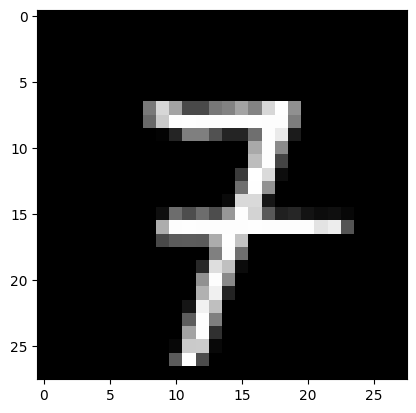

In [5]:
index = np.random.randint(0, X_train.shape[1])
image = X_train[:, index, None]
label = y_train[index]

print("Eample No:   ", f"{index}/{y_train.size}")
print("Known Label: ", label)

plt.imshow(image.reshape((28, 28)), interpolation='nearest')
plt.gray()
plt.show()

In [6]:
X_train, y_train = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.long).to(device)

W1, B1, W2, B2, training_log = gradient_descent(X=X_train, y=y_train, n_hidden=128, lr=0.1, n_iters=5192)

Iteration    0 | Loss: 2.3975 | Train Score: 0.1152
Iteration  100 | Loss: 0.4597 | Train Score: 0.8803
Iteration  200 | Loss: 0.3586 | Train Score: 0.9016
Iteration  300 | Loss: 0.3166 | Train Score: 0.9117
Iteration  400 | Loss: 0.2902 | Train Score: 0.9188
Iteration  500 | Loss: 0.2704 | Train Score: 0.9240
Iteration  600 | Loss: 0.2544 | Train Score: 0.9290
Iteration  700 | Loss: 0.2408 | Train Score: 0.9330
Iteration  800 | Loss: 0.2289 | Train Score: 0.9361
Iteration  900 | Loss: 0.2183 | Train Score: 0.9387
Iteration 1000 | Loss: 0.2089 | Train Score: 0.9415
Iteration 1100 | Loss: 0.2002 | Train Score: 0.9433
Iteration 1200 | Loss: 0.1923 | Train Score: 0.9457
Iteration 1300 | Loss: 0.1850 | Train Score: 0.9482
Iteration 1400 | Loss: 0.1782 | Train Score: 0.9501
Iteration 1500 | Loss: 0.1718 | Train Score: 0.9519
Iteration 1600 | Loss: 0.1659 | Train Score: 0.9536
Iteration 1700 | Loss: 0.1604 | Train Score: 0.9550
Iteration 1800 | Loss: 0.1553 | Train Score: 0.9567
Iteration 19

In [7]:
print(pd.DataFrame(training_log).head().to_string())
print(pd.DataFrame(training_log).tail().to_string())

   train_loss  train_acc
0    2.397507   0.115220
1    0.459653   0.880293
2    0.358649   0.901634
3    0.316635   0.911683
4    0.290192   0.918805
    train_loss  train_acc
47    0.076964   0.979902
48    0.075518   0.980146
49    0.074112   0.980537
50    0.072749   0.980780
51    0.071423   0.981073


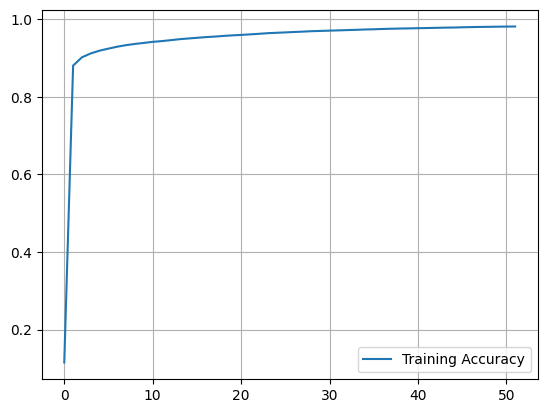

In [8]:
t=(range(0,len(training_log['train_acc'])))
plt.plot(t, training_log['train_acc'], label='Training Accuracy')
plt.legend()
plt.grid()
plt.show()

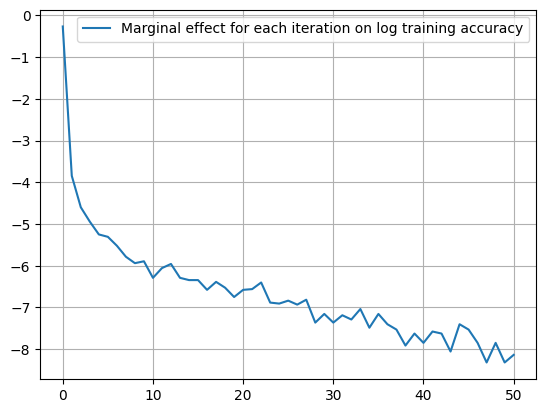

In [9]:
dydx_t = range(len(training_log['train_acc']) - 1)
dydx_acc = [training_log['train_acc'][i+1] - training_log['train_acc'][i] 
            for i in dydx_t]

plt.plot(dydx_t, np.log(dydx_acc), label='Marginal effect for each iteration on log training accuracy')
plt.legend()
plt.grid()
plt.show()

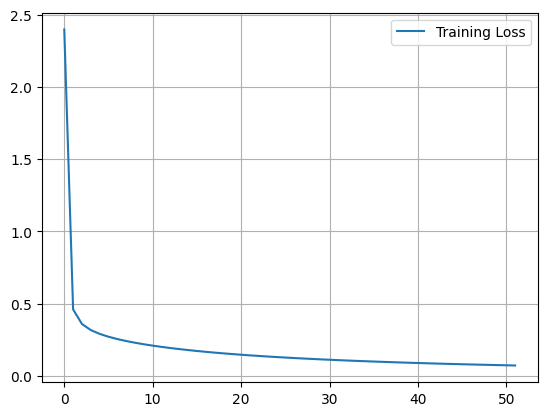

In [10]:
plt.plot(t, training_log['train_loss'], label="Training Loss")
plt.legend()
plt.grid()
plt.show()

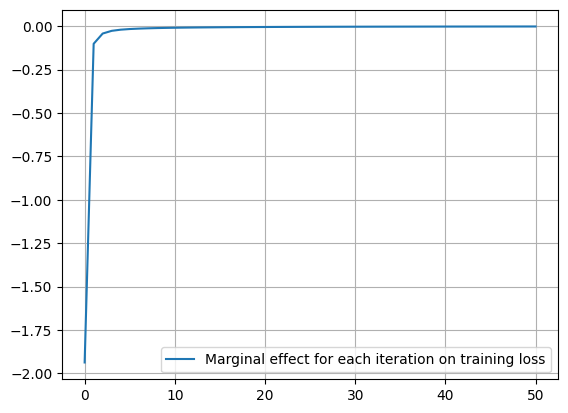

In [11]:
dydx_t = range(len(training_log['train_loss']) - 1)
dydx_loss = [training_log['train_loss'][i+1] - training_log['train_loss'][i] 
            for i in dydx_t]

plt.plot(dydx_t, dydx_loss, label='Marginal effect for each iteration on training loss')
plt.legend()
plt.grid()
plt.show()

In [12]:
'''Training Score'''

_, _, _, A2 = forward_prop(W1, B1, W2, B2, X_train)
y_prediction = predict(A2)
score(y_prediction, y_train)

0.9813902378082275

In [13]:
'''Test score'''

_, _, _, A2 = forward_prop(W1, B1, W2, B2, X_test)
y_prediction = predict(A2)
score(y_prediction, y_test)

0.9640000462532043

Eample No:         38216/41000
Known Label:       9
Model Prediction:  7
Prediction:        False
Confidence:        Moderate: 73.21%

Network Reasoning
7    73.209999
9    25.760000
3     0.430000
2     0.200000
5     0.180000
1     0.070000
4     0.070000
8     0.060000
0     0.020000
6     0.000000


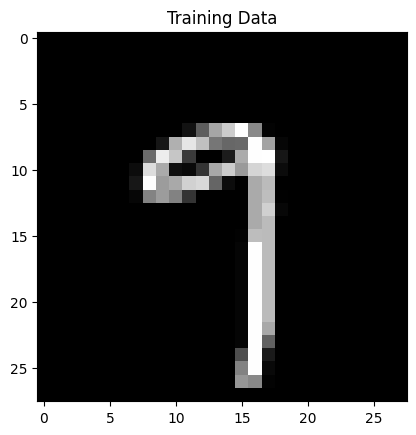

In [14]:
'''Predicting random number from the training set'''

index = np.random.randint(0, X_train.shape[1])
image = X_train[:, index, None]
label = y_train[index]

_, _, _, A2 = forward_prop(W1, B1, W2, B2, image)
prediction = predict(A2)

A2_np = A2.flatten().detach().cpu().numpy()       # for pandas
image_np = image.detach().cpu().numpy()           # for matplotlib
label_np = label.detach().cpu().item()            # scalar label
prediction_np = prediction.detach().cpu().item()  # scalar prediction

confidence = pd.Series(A2_np)
levels = {
    0.9: "High",
    0.7: "Moderate",
    0.5: "Low",
    0.0: "Not Significant",
}
conf_level = [levels[threshold] for threshold in levels.keys() if confidence.max() >= threshold]

print("Eample No:        ", f"{index}/{y_train.detach().cpu().numpy().size}")
print("Known Label:      ", label_np)
print("Model Prediction: ", prediction_np)
print("Prediction:       ", prediction_np==label_np)
print(f"Confidence:        {conf_level[0]}: {confidence.max():.2%}")
print(f"\nNetwork Reasoning\n{round(confidence*100,2).sort_values(ascending=False).to_string()}")
plt.title("Training Data")
plt.imshow(image_np.reshape((28, 28)) * 255, interpolation='nearest')
plt.gray()
plt.show()

Eample No:         126/1000
Known Label:       7
Model Prediction:  7
Prediction:        True
Confidence:        High: 99.73%

Network Reasoning
7    99.730003
2     0.130000
9     0.080000
3     0.050000
1     0.000000
0     0.000000
5     0.000000
4     0.000000
6     0.000000
8     0.000000


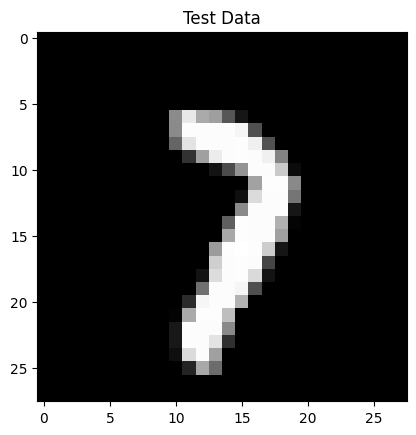

In [15]:
'''Predicting random number from the test set'''

index = np.random.randint(0, X_test.shape[1])
image = X_test[:, index, None]
label = y_test[index]

_, _, _, A2 = forward_prop(W1, B1, W2, B2, image)
prediction = predict(A2)

A2_np = A2.flatten().detach().cpu().numpy()       # for pandas
image_np = image.detach().cpu().numpy()           # for matplotlib
label_np = label.detach().cpu().item()            # scalar label
prediction_np = prediction.detach().cpu().item()  # scalar prediction

confidence = pd.Series(A2_np)
levels = {
    0.9: "High",
    0.7: "Moderate",
    0.5: "Low",
    0.0: "Not Significant",
}
conf_level = [levels[threshold] for threshold in levels.keys() if confidence.max() >= threshold]

print("Eample No:        ", f"{index}/{y_test.detach().cpu().numpy().size}")
print("Known Label:      ", label_np)
print("Model Prediction: ", prediction_np)
print("Prediction:       ", prediction_np==label_np)
print(f"Confidence:        {conf_level[0]}: {confidence.max():.2%}")
print(f"\nNetwork Reasoning\n{round(confidence*100,2).sort_values(ascending=False).to_string()}")
plt.title("Test Data")
plt.imshow(image_np.reshape((28, 28)) * 255, interpolation='nearest')
plt.gray()
plt.show()